In [1]:
import numpy as np
import glob
import os
from models.JetPointNet import PointNetSegmentation


def load_data_from_npz(npz_file):
    data = np.load(npz_file)
    feats = data['feats']  # Shape: (num_samples, 859, 6)
    frac_labels = data['frac_labels']  # Shape: (num_samples, 859)
    tot_labels = data['tot_labels']  # Shape: (num_samples, 859)
    tot_truth_e = data['tot_truth_e']  # Shape: (num_samples, 859) (This is the true total energy deposited by particles into this cell)
    return feats, frac_labels, tot_labels, tot_truth_e

# Setup
os.environ['CUDA_VISIBLE_DEVICES'] = ""  # Disable GPU
abs_model_path = "saved_model/PointNetModel.keras"

TEST_DIR = '/data/mjovanovic/jets/processed_files/2000_events_w_fixed_hits/SavedNpz/test'

abs_model = PointNetSegmentation(num_points=859, num_classes=1)
abs_model.load_weights(abs_model_path)

npz_files = glob.glob(os.path.join(TEST_DIR, '*.npz'))



2024-04-11 16:48:16.831517: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9360] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-11 16:48:16.831824: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-11 16:48:16.832012: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1537] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-11 16:48:16.849346: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-11 16:48:19.795323: E tensor

13/13 [==============================] - 13s 933ms/step
Predicted Energy:  248.6263
True Energy:  7583.123
Percentage Difference:  96.72131833669495 % 


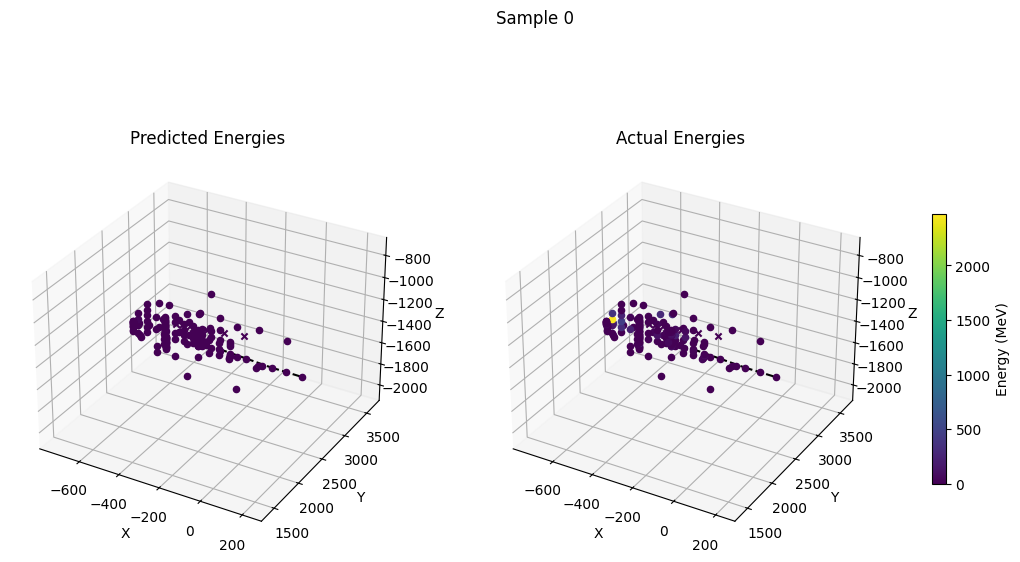

Predicted Energy:  645.85596
True Energy:  6367.1475
Percentage Difference:  89.85643161253007 % 


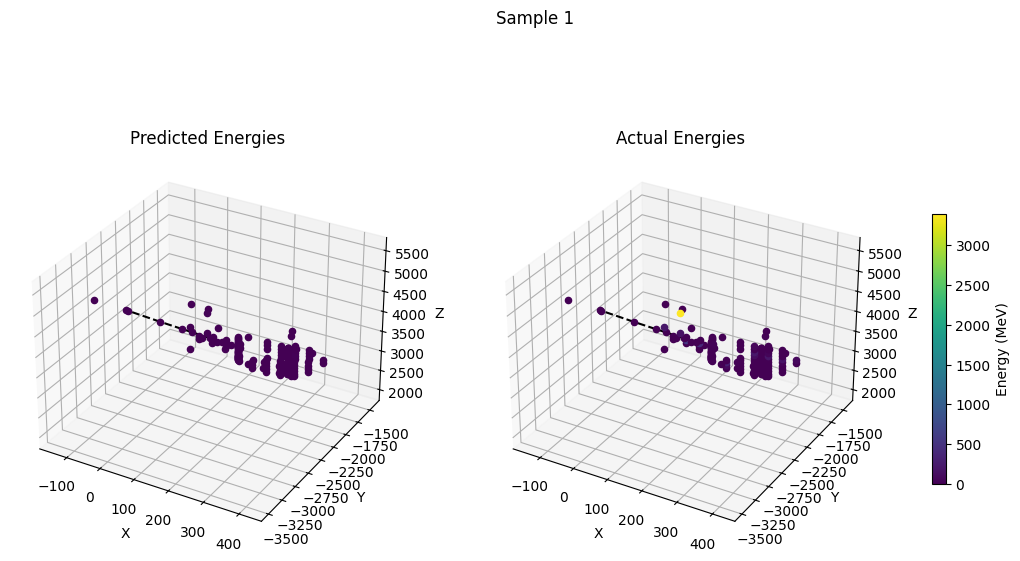

Predicted Energy:  482.20038
True Energy:  29393.334
Percentage Difference:  98.35948799775034 % 


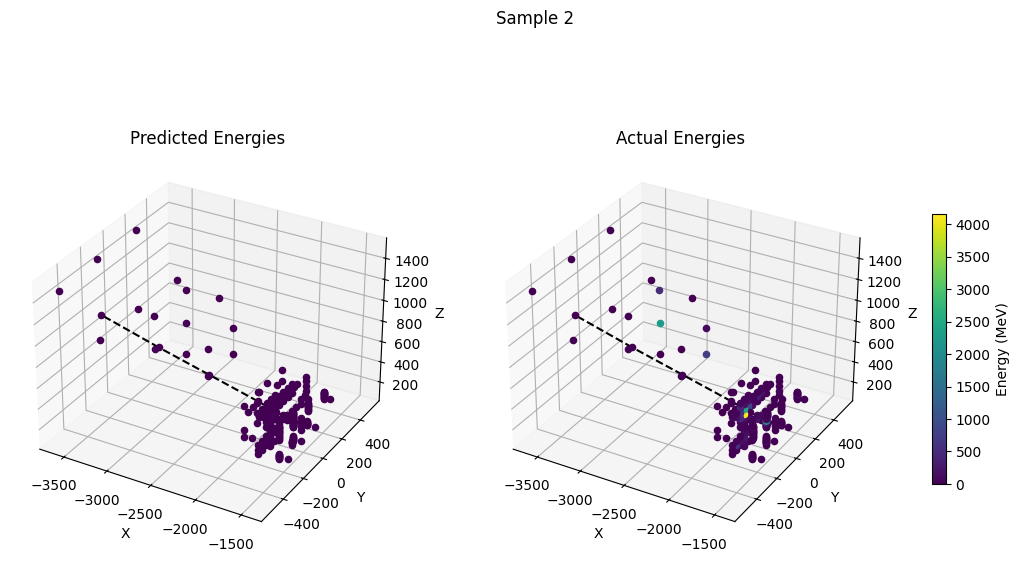

Predicted Energy:  568.7812
True Energy:  15073.28
Percentage Difference:  96.22655958303702 % 


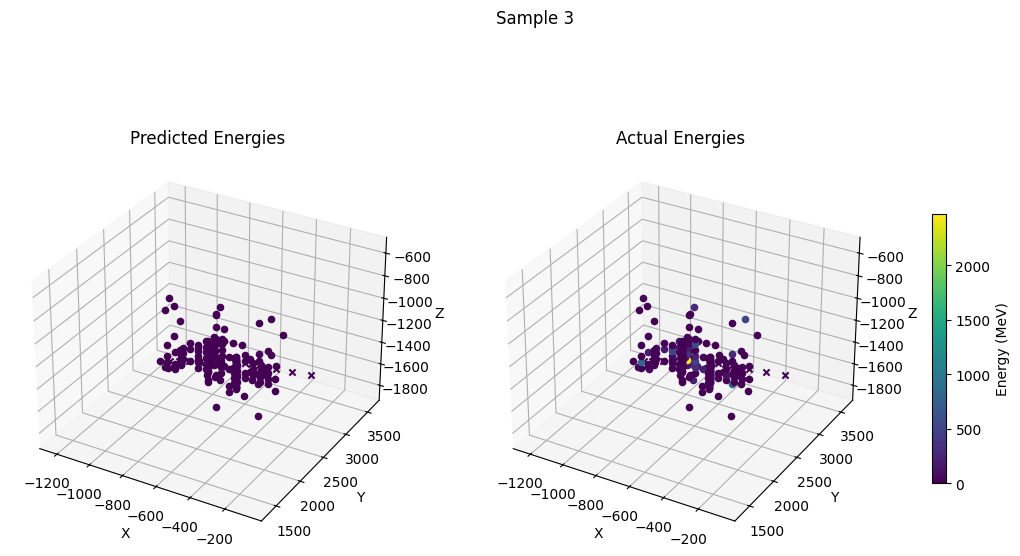

Predicted Energy:  234.53484
True Energy:  65.23077
Percentage Difference:  259.54635636070344 % 


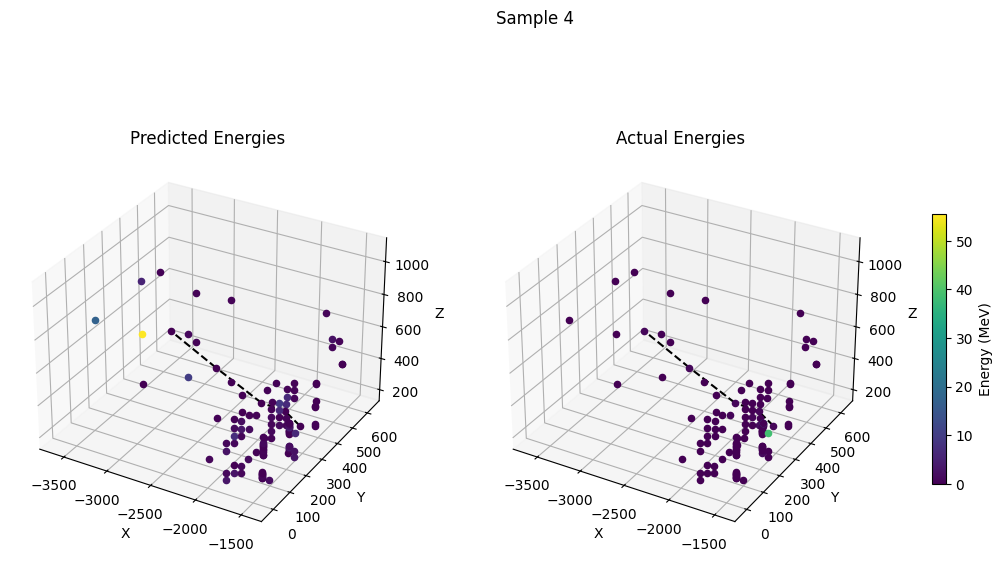

Predicted Energy:  512.4087
True Energy:  4411.5977
Percentage Difference:  88.38496319626269 % 


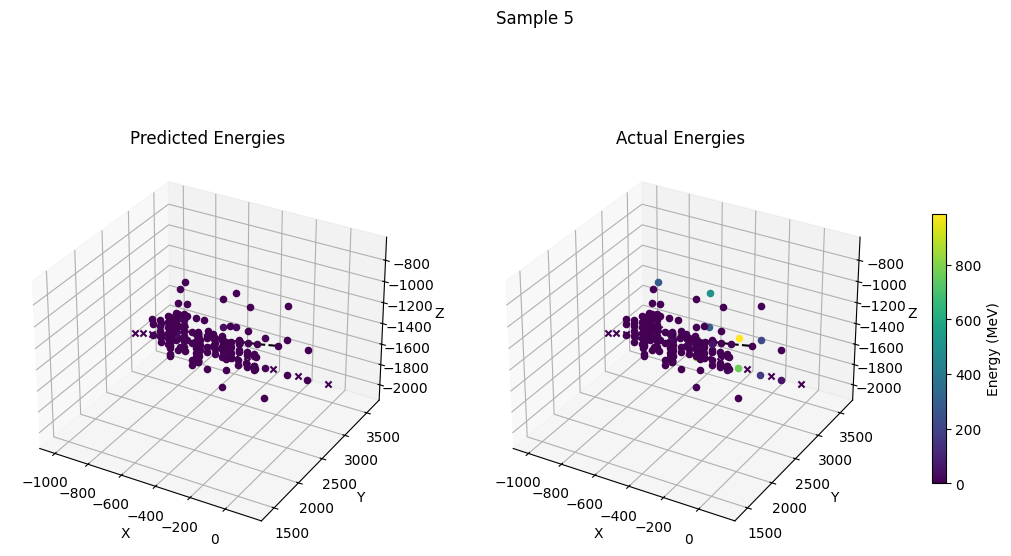

Predicted Energy:  420.64594
True Energy:  817.6396
Percentage Difference:  48.553624171379255 % 


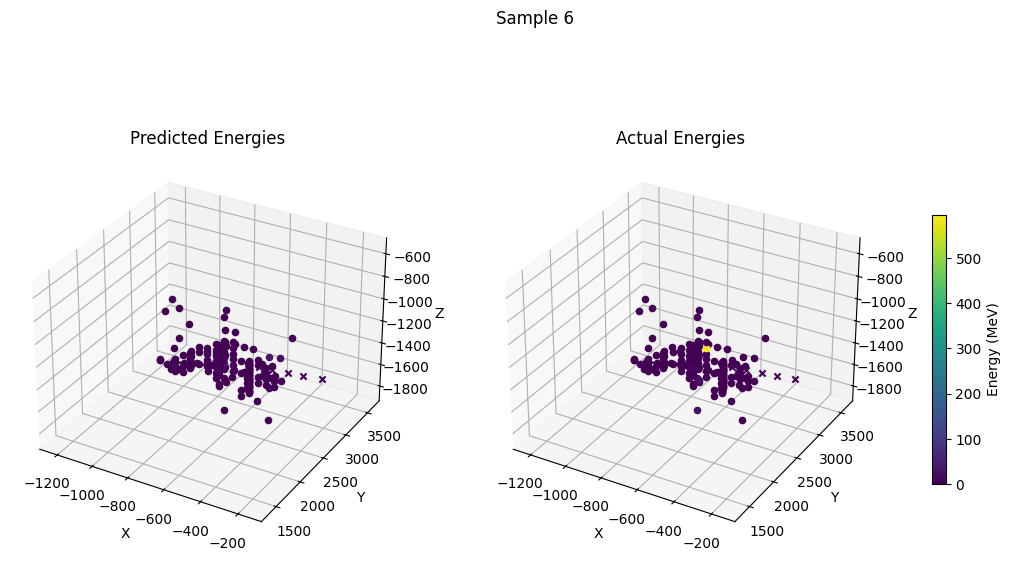

Predicted Energy:  99.03232
True Energy:  507.77164
Percentage Difference:  80.49668179428622 % 


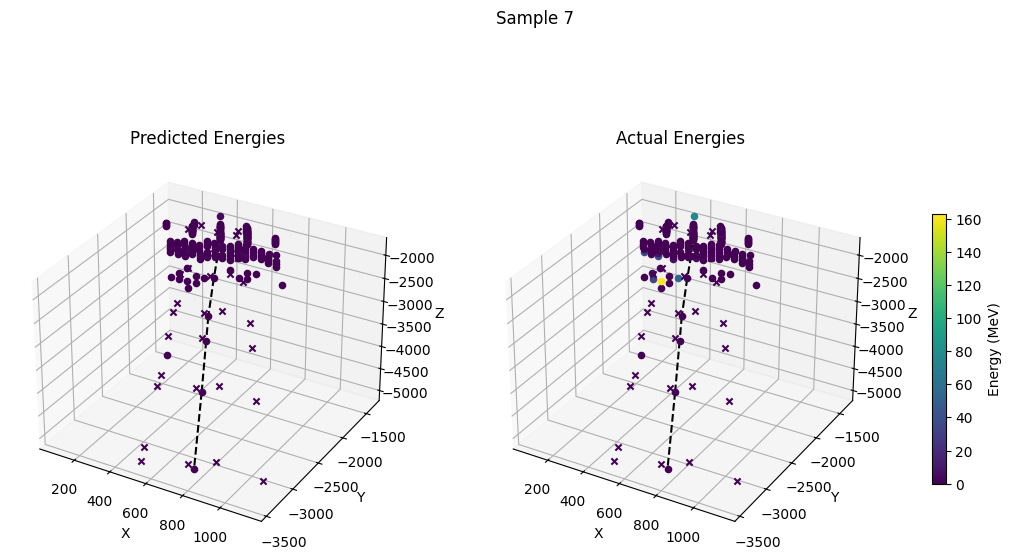

Predicted Energy:  9573.805
True Energy:  396.6472
Percentage Difference:  2313.682674178976 % 


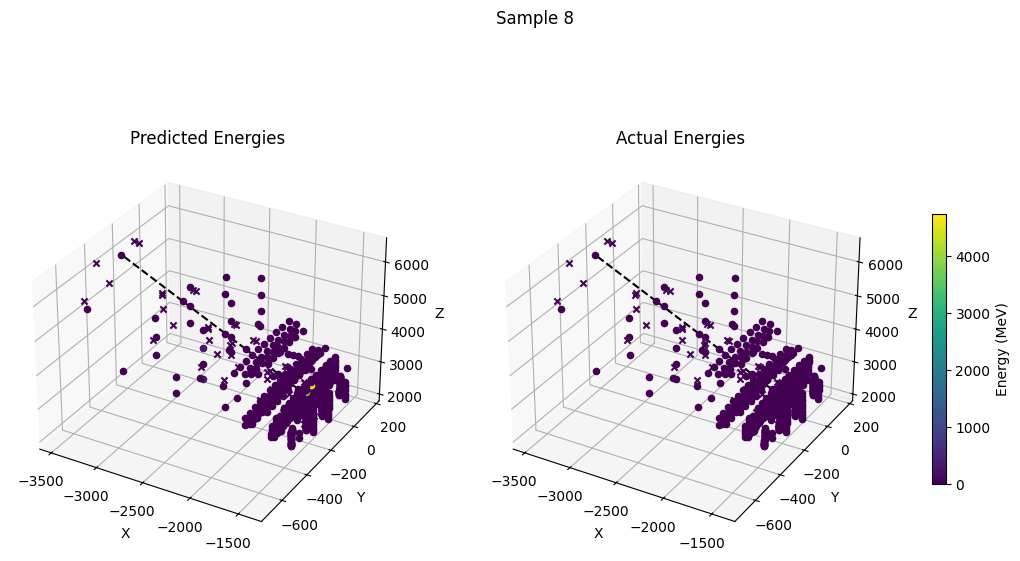

Predicted Energy:  878.5941
True Energy:  1142.1328
Percentage Difference:  23.074260138994344 % 


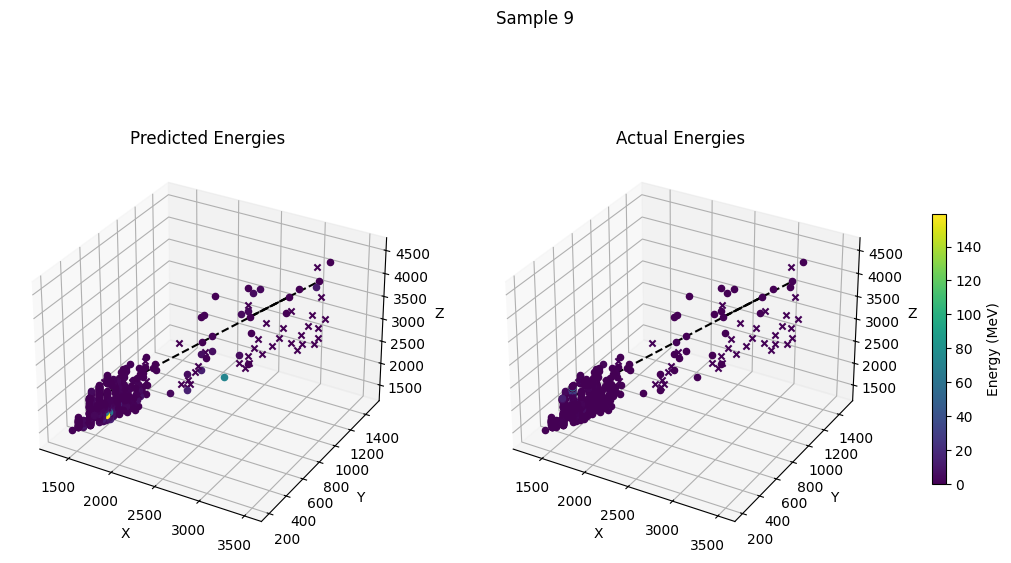

15/15 [==============================] - 14s 911ms/step
Predicted Energy:  189.85283
True Energy:  37120.35
Percentage Difference:  99.48855128114737 % 


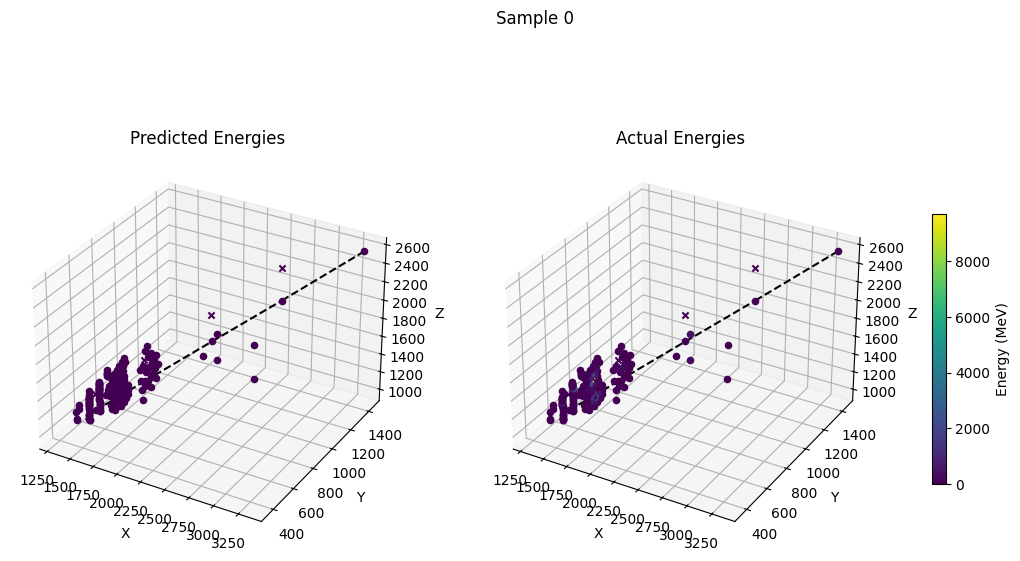

Predicted Energy:  245.8135
True Energy:  5242.13
Percentage Difference:  95.31080911656817 % 


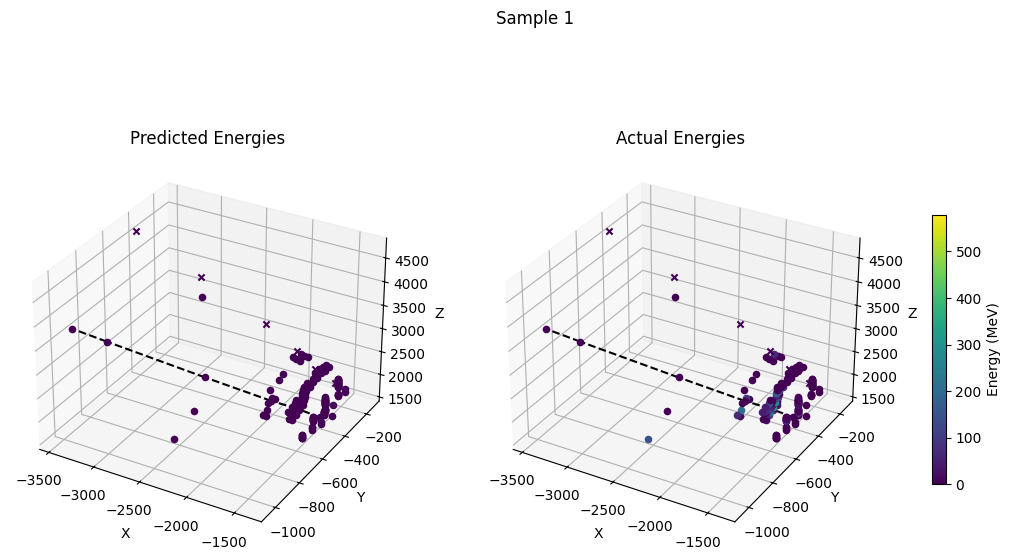

Predicted Energy:  212.44391
True Energy:  101.92096
Percentage Difference:  108.43986339080877 % 


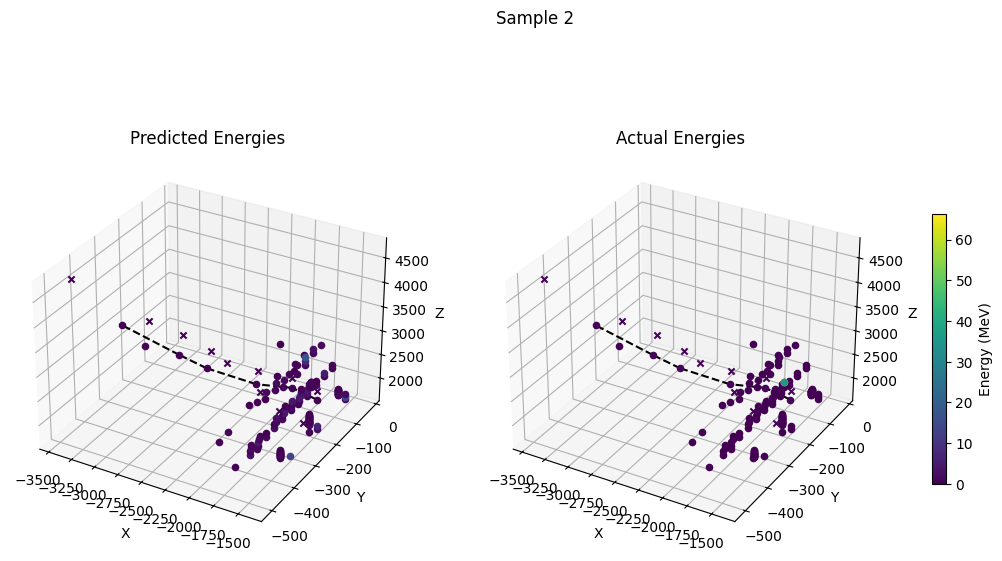

Predicted Energy:  10523.424
True Energy:  1018.2727
Percentage Difference:  933.458327988693 % 


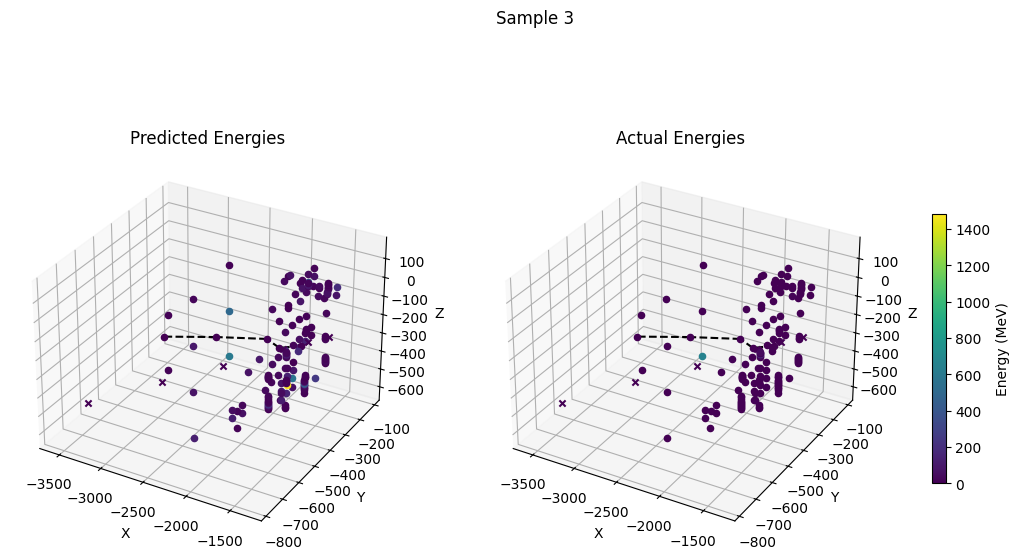

Predicted Energy:  9671.203
True Energy:  6624.6875
Percentage Difference:  45.98731072220388 % 


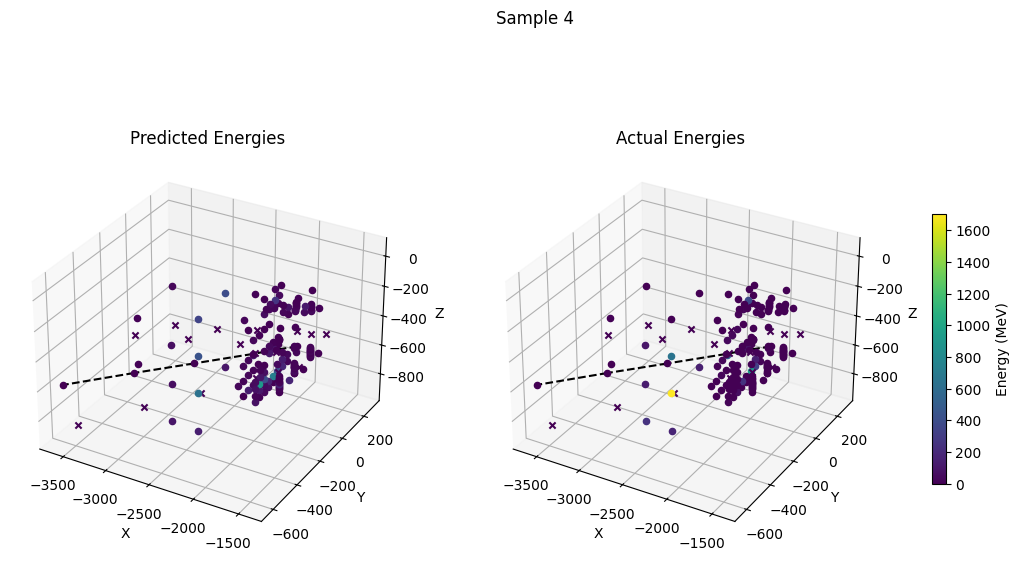

Predicted Energy:  47.273163
True Energy:  6361.9316
Percentage Difference:  99.25694031484271 % 


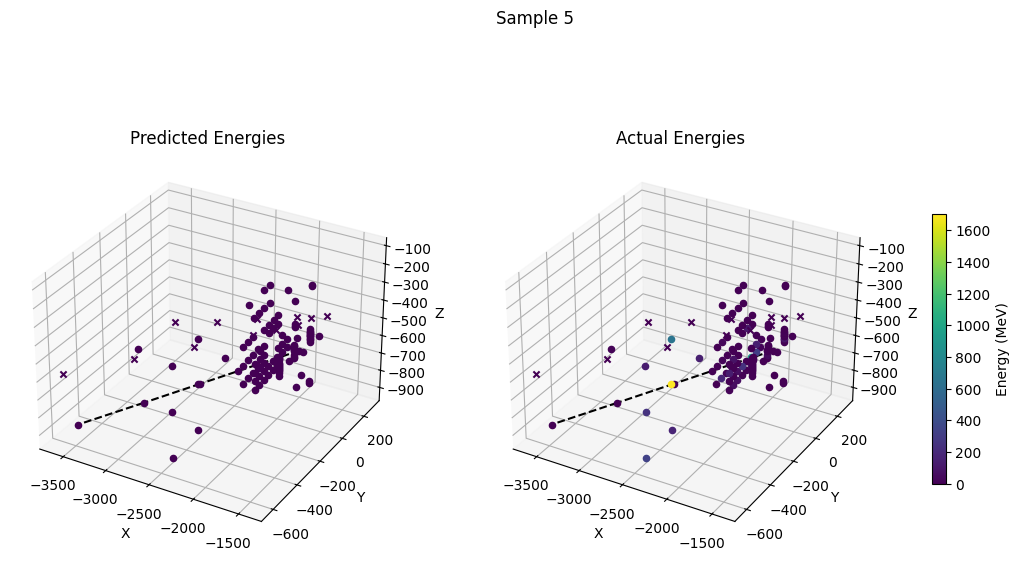

Predicted Energy:  343.31155
True Energy:  38406.637
Percentage Difference:  99.10611152308373 % 


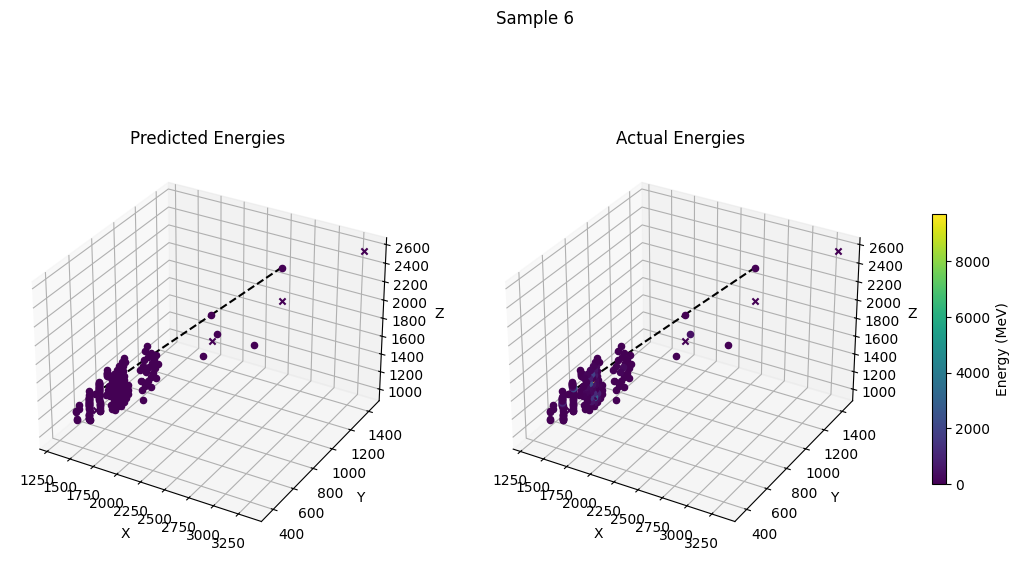

Predicted Energy:  257.74512
True Energy:  841.84656
Percentage Difference:  69.38336150984128 % 


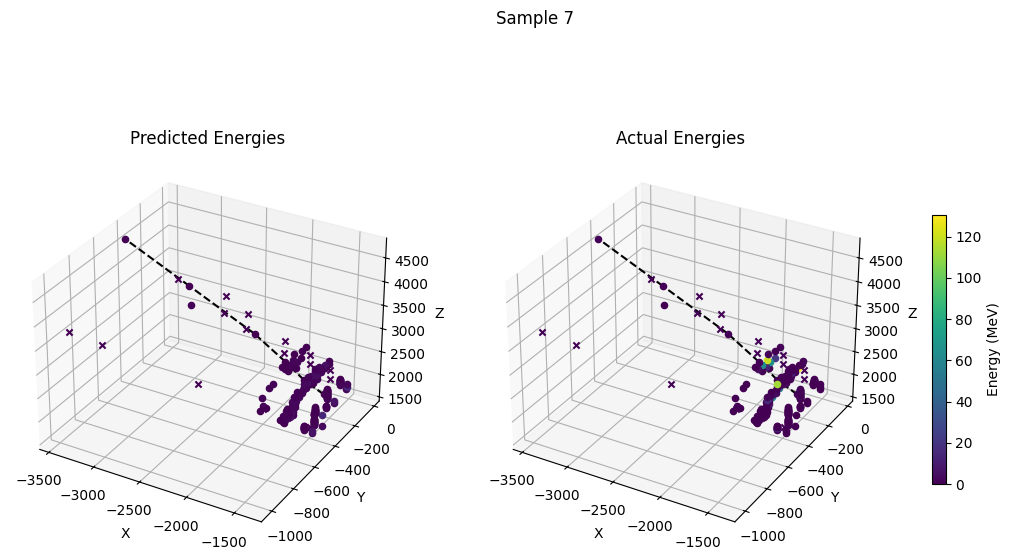

Predicted Energy:  129.31216
True Energy:  0.0
Percentage Difference:  inf % 


/tmp/ipykernel_3951766/3003607767.py:75: RuntimeWarning: divide by zero encountered in scalar divide
  print("Percentage Difference: ", 100 * np.abs(tot_predicted - tot_true) / tot_true, "% ")


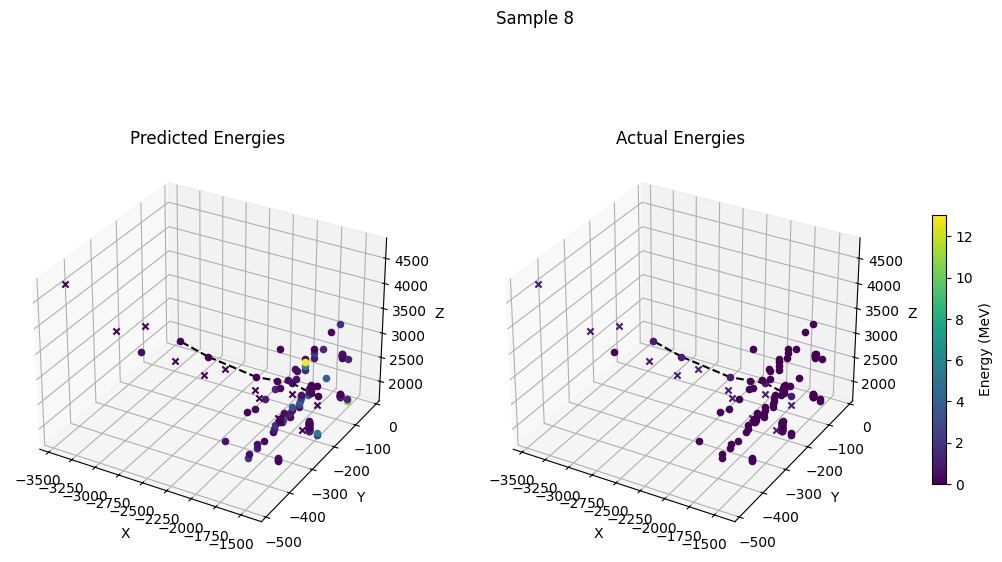

Predicted Energy:  4048.9175
True Energy:  4356.011
Percentage Difference:  7.049884257689429 % 


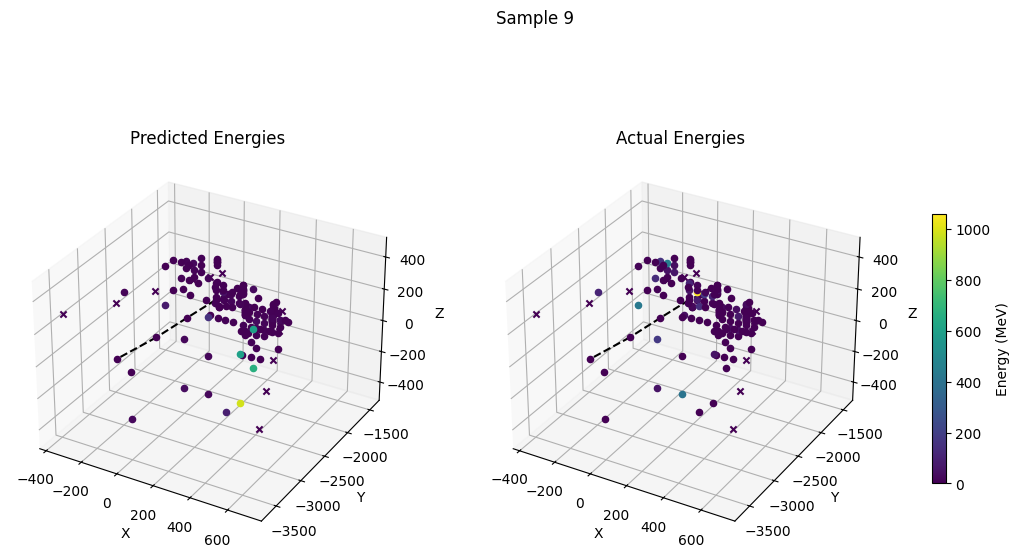

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

def plot_energies(predicted_energies, true_energies, coords, types, sample_index):
    fig = plt.figure(figsize=(14, 7))
    ax1 = fig.add_subplot(121, projection='3d')
    ax2 = fig.add_subplot(122, projection='3d')

    ax1.set_title('Predicted Energies')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')
    ax2.set_title('Actual Energies')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_zlabel('Z')

    vmax = np.max([predicted_energies, true_energies])  # Ensure the color bar covers the full range of both datasets

    # Create a dummy scatter object for colorbar reference
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=0, vmax=vmax))
    sm.set_array([])  # You have to set_array for ScalarMappable

    # Plotting with individual configurations
    for i, t in enumerate(types):
        color = 'r' if t == 2 else 'b'
        marker = 'x' if t == 2 else 'o'
        linestyle = 'k--' if t == 1 else 'none'

        if t == -1:
            continue

        scatter1 = ax1.scatter(coords[i, 0], coords[i, 1], coords[i, 2], c=[predicted_energies[i]], cmap='viridis', vmin=0, vmax=vmax, marker=marker)
        scatter2 = ax2.scatter(coords[i, 0], coords[i, 1], coords[i, 2], c=[true_energies[i]], cmap='viridis', vmin=0, vmax=vmax, marker=marker)

        if i > 0 and types[i-1] == 1 and t == 1:
            ax1.plot([coords[i-1, 0], coords[i, 0]], [coords[i-1, 1], coords[i, 1]], [coords[i-1, 2], coords[i, 2]], 'k--')
            ax2.plot([coords[i-1, 0], coords[i, 0]], [coords[i-1, 1], coords[i, 1]], [coords[i-1, 2], coords[i, 2]], 'k--')

    plt.suptitle(f'Sample {sample_index}')

    # Add a color bar using the ScalarMappable we created. Place it on the right of the second plot.
    cbar = fig.colorbar(sm, ax=[ax1, ax2], shrink=0.5, aspect=20)
    cbar.set_label('Energy (MeV)')

    plt.show()

# Process each file
for npz_file_idx, npz_file in enumerate(npz_files):
    if npz_file_idx > 1:  # Only plot the first 10 samples
        break
    feats, frac_labels, tot_labels, tot_truth_e = load_data_from_npz(npz_file)
    abs_predicted = np.abs(np.squeeze(abs_model.predict(feats), axis=-1))

    for sample_idx in range(min(10, len(feats))):
        types = feats[sample_idx][:, -1]
        valid_indices = types != -1  # Exclude -1 types for plotting

        # Extract coordinates and types for plotting
        coords = feats[sample_idx][valid_indices, :3]
        types_for_plotting = types[valid_indices]

        # For energy evaluation, consider only type 0
        energy_indices = types == 0
        predicted_energies_eval = abs_predicted[sample_idx] * energy_indices
        true_energies_eval = tot_labels[sample_idx] * energy_indices

        #print(predicted_energies_eval)

        tot_predicted = np.sum(predicted_energies_eval)
        tot_true = np.sum(true_energies_eval)
        print("Predicted Energy: ", tot_predicted)
        print("True Energy: ", tot_true)
        print("Percentage Difference: ", 100 * np.abs(tot_predicted - tot_true) / tot_true, "% ")
        #print(predicted_energies_eval)
        #print(true_energies_eval)

        # Convert types for energy evaluation to boolean for indexing, zero out non-type 0 energies
        predicted_energies_plot = np.abs(abs_predicted[sample_idx][valid_indices])
        true_energies_plot = np.abs(tot_labels[sample_idx][valid_indices])

        # Plot with adjusted energies
        plot_energies(predicted_energies_plot, true_energies_plot, coords, types_for_plotting, sample_idx)
